## Task
I want to develop the preprocessing and training for every company up to the 1000 data points. 
<br>
In this code only the data such as the daily high, low, close, ect. is used.
<br>
The code makes to predictions on the data, the first being if their is an increase or decrease in the price. The second being the exact price prediction. As can be seen the LSTM models perfrom better on the exact price prediction than the classical methods. The binary classification task is better performed by the classical methods.

<br>


Scale training and testing independently

In [57]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import datetime as dt

from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Dropout, BatchNormalization

from sklearn.metrics import classification_report, confusion_matrix


In [58]:
"""
file = open('stocks_name.txt','r')

Files = []

for line in file:
    line = re.sub('\n', '', line)
    line = line.split('\t')
    if line[1][2:4] == '.A':
        Files.append('csv/BT-A.L.csv')
    elif line[1][2] == '.':
        Files.append('csv/' + line[1] + 'L.csv')
    else:
        Files.append('csv/' + line[1] + '.L.csv')
"""

"\nfile = open('stocks_name.txt','r')\n\nFiles = []\n\nfor line in file:\n    line = re.sub('\n', '', line)\n    line = line.split('\t')\n    if line[1][2:4] == '.A':\n        Files.append('csv/BT-A.L.csv')\n    elif line[1][2] == '.':\n        Files.append('csv/' + line[1] + 'L.csv')\n    else:\n        Files.append('csv/' + line[1] + '.L.csv')\n"

A look at the data and the scaling.

,Open,High,Low,Close,Adj Close,Volume,pred
Date,,,,,,,
2014-01-02,340.299988,342.303009,339.299988,340.100006,296.714508,5388659,343.299988
2014-01-03,340.200012,346.600006,339.700012,343.299988,299.506317,6959765,344.299988
2014-01-06,343.100006,346.700012,340.000000,344.299988,300.378754,6390175,350.399994
2014-01-07,342.500000,353.209015,341.975006,350.399994,305.700592,8424859,357.899994
2014-01-08,350.700012,362.011993,348.799988,357.899994,312.243835,13663852,360.200012


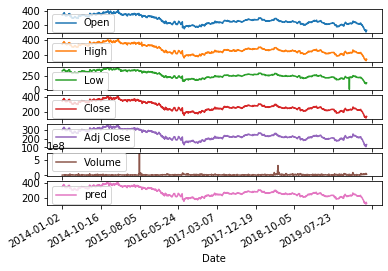

In [59]:
df = pd.read_csv('csv/RBS.L.csv')

# Sort DataFrame by date
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

#Add a predicting column
df['pred'] = df.Close.shift(-1)

df = df.dropna()

df.plot(subplots=True)

df.head()

,High,Low,Open,Close,Volume,Adj Close,pred
0,0.773944,0.756753,0.848678,0.780605,0.771328,0.007522,0.791609
1,0.773616,0.771332,0.849685,0.791609,0.782798,0.009715,0.795048
2,0.783144,0.771671,0.850441,0.795048,0.786382,0.008920,0.816025
3,0.781173,0.793754,0.855413,0.816025,0.808246,0.011761,0.841816
4,0.808116,0.823620,0.872598,0.841816,0.835127,0.019074,0.849725


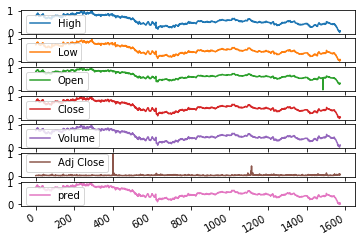

In [60]:
#Scale the data frame

values = df.values
values = values.astype('float32')


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled = scaler.fit_transform(values)

scaled = pd.DataFrame(scaled)

scaled.columns = ["High", "Low", "Open", "Close",'Volume','Adj Close','pred']

scaled.plot(subplots=True)
scaled.head()

In [61]:
s = scaled.drop(['pred'],axis=1)
s.head(10)

,High,Low,Open,Close,Volume,Adj Close
0,0.773944,0.756753,0.848678,0.780605,0.771328,0.007522
1,0.773616,0.771332,0.849685,0.791609,0.782798,0.009715
2,0.783144,0.771671,0.850441,0.795048,0.786382,0.008920
3,0.781173,0.793754,0.855413,0.816025,0.808246,0.011761
4,0.808116,0.823620,0.872598,0.841816,0.835127,0.019074
5,0.837030,0.835104,0.892740,0.849725,0.843371,0.019225
6,0.845901,0.825954,0.892489,0.838377,0.831543,0.014535
7,0.843601,0.844275,0.904071,0.876547,0.871327,0.014665
8,0.843601,0.853724,0.902560,0.882050,0.877062,0.012790
9,0.873829,0.879559,0.925976,0.900619,0.896417,0.015712


In [62]:
# This function produces the data for the model by combining the data for 'size' number of days before and predicting 'delay'
# number of days 
def window(data, size, delay):
    
    windows = []
    binary_pred = []
    pred = []

    for i in range(len(scaled['Close'])-delay):
        if scaled['Close'][i+delay] > scaled['Close'][i]:
            binary_pred.append(1)
        else:
            binary_pred.append(0)

            
    for i in range(len(scaled['Close'])-delay):
        pred.append(scaled['Close'][i+delay])
            
    for j in range(len(data)-size):
        d = []
        for i in range(size):
            d.append(data[j + i])
        windows.append(np.concatenate(d))
    
    move = abs(size - delay)

    if size > delay:
        pred = pred[:-move]
        binary_pred = binary_pred[:-move]
    elif size < delay:
        windows = windows[:-move]
        
        
    return windows, binary_pred, pred
  
data = s.values
data, binary_pred, pred  = window(data,size = 40, delay=10)


In [63]:
  
data = s.values
data, binary_pred, pred  = window(data,size = 30, delay=10)

print(len(data))
X_train = data[:1000]
X_test = data[1000:]
y_train = binary_pred[:1000]
y_test = binary_pred[1000:]
#= train_test_split(data, binary_pred, test_size=0.2, random_state=42)

X_train, y_train = shuffle(X_train,y_train,  random_state=2)

clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

Svm = svm.SVC(C=1)
Svm.fit(X_train, y_train)

Svr = svm.SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0,
              tol=0.001, C=1.2, epsilon=0.1, shrinking=False, cache_size=100, verbose=False, max_iter=-1)
Svr.fit(X_train, y_train)

mod = XGBClassifier()
mod.fit(np.array(X_train), np.array(y_train))

print('log reg : ', clf.score(X_test, y_test))
print('SVM : ', Svm.score(X_test, y_test))
print('SVR : ', Svr.score(X_test, y_test))
print('XGBoost : ', mod.score(np.array(X_test), np.array(y_test)))

1544
log reg :  0.9191176470588235
SVM :  0.8363970588235294
SVR :  0.5164190517638103
XGBoost :  0.8547794117647058


1544
0.0009761473047115908


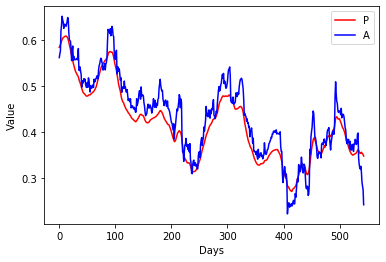

In [64]:
X_train = data[:1000]
X_test = data[1000:]
y_train = pred[:1000]
y_test = pred[1000:]

X_train, y_train = shuffle(X_train,y_train,  random_state=2)

Svr = svm.SVR()
print(len(pred))
Svr.fit(X_train, y_train)

Pred = Svr.predict(X_test)
print(mean_squared_error(y_test, Pred))

plt.plot(range(len(Pred)),Pred, color = 'red')
plt.plot(range(len(Pred)),y_test,color='blue')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend('PA')
plt.show()

In [69]:
print(np.array(X_train).shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = np.array(X_train).reshape((np.array(X_train).shape[0], 1,np.array(X_train).shape[1]))
test_X = np.array(X_test).reshape((np.array(X_test).shape[0], 1, np.array(X_test).shape[1]))


Model = Sequential()
Model.add(LSTM(180, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
Model.add(LSTM(units=90, return_sequences=True))
#model.add(BatchNormalization())
Model.add(LSTM(units=30))
Model.add(Dense(units=1, activation='relu'))

Model.compile(loss='mae', optimizer='adam', metrics=['mse'])
Model.summary()

(1000, 180)
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 1, 180)            259920    
_________________________________________________________________
lstm_38 (LSTM)               (None, 1, 90)             97560     
_________________________________________________________________
lstm_39 (LSTM)               (None, 30)                14520     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 31        
Total params: 372,031
Trainable params: 372,031
Non-trainable params: 0
_________________________________________________________________


In [70]:
Model.fit(train_X,np.array(y_train), epochs=80, batch_size=64,shuffle = False,validation_split=0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/80
800/800 [==============================] - 3s 3ms/step - loss: 0.3318 - mse: 0.1643 - val_loss: 0.1562 - val_mse: 0.0289
Epoch 2/80
800/800 [==============================] - 0s 473us/step - loss: 0.1060 - mse: 0.0170 - val_loss: 0.0778 - val_mse: 0.0078
Epoch 3/80
800/800 [==============================] - 0s 399us/step - loss: 0.0670 - mse: 0.0068 - val_loss: 0.0512 - val_mse: 0.0035
Epoch 4/80
800/800 [==============================] - 0s 335us/step - loss: 0.0349 - mse: 0.0020 - val_loss: 0.0296 - val_mse: 0.0015
Epoch 5/80
800/800 [==============================] - 0s 310us/step - loss: 0.0268 - mse: 0.0012 - val_loss: 0.0269 - val_mse: 0.0013
Epoch 6/80
800/800 [==============================] - 0s 351us/step - loss: 0.0254 - mse: 0.0012 - val_loss: 0.0277 - val_mse: 0.0013
Epoch 7/80
800/800 [==============================] - 0s 481us/step - loss: 0.0242 - mse: 0.0010 - val_loss: 0.0235 - val_mse: 9.7902e-04
Epoch 8/80
800

0.0001695497


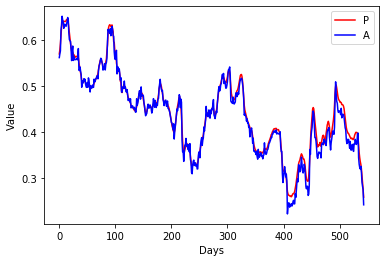

534 534
0.9288389513108615


In [71]:
Pred = Model.predict(test_X)
print(mean_squared_error(y_test, Pred))
a=0
b=len(Pred)
plt.plot(range(b),Pred[a:a+b], color = 'red')
plt.plot(range(b),y_test[a:a+b],color='blue')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend('PA')
plt.show()

#y_test = pred[1000:]
print(len(y_test[:-10]), len(Pred[10:]))

actual = y_test[10:]
predicted = Pred[10:]
p = []
a = []
for i in range(len(Pred[:-10])):
    if predicted[i] < y_test[i]:
        p.append(0)
    else:
        p.append(1)
    
    if actual[i] < y_test[i]:
        a.append(0)
    else:
        a.append(1)
        
score = 0
for i in range(len(a)):
    if a[i] == p[i]:
        score += 1
print(score/len(a))

In [26]:
#model.save('Good10day.h5')

0.0024112507


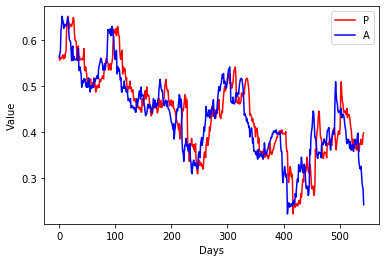

In [72]:
#Same as day before
delay = 10

y_test = pred[1000 - delay:]

Pred = []
for i in range(len(y_test)-delay):
    Pred.append(y_test[i])

print(mean_squared_error(y_test[delay:], Pred))

plt.plot(range(len(Pred)),Pred, color = 'red')
plt.plot(range(len(Pred)),y_test[delay:],color='blue')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend('PA')
plt.show()


In [73]:
model = Sequential()
model.add(LSTM(180, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(LSTM(units=90, return_sequences=True))
#model.add(BatchNormalization())
model.add(LSTM(units=30))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 1, 180)            259920    
_________________________________________________________________
batch_normalization_9 (Batch (None, 1, 180)            720       
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 180)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 1, 90)             97560     
_________________________________________________________________
lstm_42 (LSTM)               (None, 30)                14520     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 31        
Total params: 372,751
Trainable params: 372,391
Non-trainable params: 360
_____________________________________________

In [48]:
y_train = binary_pred[:1000]
y_test = binary_pred[1000:]

model.fit(train_X,np.array(y_train), epochs=40, batch_size=64,shuffle = False,validation_split = 0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/40
800/800 [==============================] - 2s 2ms/step - loss: 0.4796 - accuracy: 0.5175 - val_loss: 0.5062 - val_accuracy: 0.4900
Epoch 2/40
800/800 [==============================] - 0s 360us/step - loss: 0.4646 - accuracy: 0.5275 - val_loss: 0.5008 - val_accuracy: 0.4900
Epoch 3/40
800/800 [==============================] - 0s 408us/step - loss: 0.4543 - accuracy: 0.5475 - val_loss: 0.4937 - val_accuracy: 0.4950
Epoch 4/40
800/800 [==============================] - 0s 366us/step - loss: 0.4544 - accuracy: 0.5562 - val_loss: 0.4934 - val_accuracy: 0.4900
Epoch 5/40
800/800 [==============================] - 0s 312us/step - loss: 0.4472 - accuracy: 0.5575 - val_loss: 0.4907 - val_accuracy: 0.5200
Epoch 6/40
800/800 [==============================] - 0s 303us/step - loss: 0.4522 - accuracy: 0.5587 - val_loss: 0.4938 - val_accuracy: 0.4900
Epoch 7/40
800/800 [==============================] - 0s 292us/step - loss: 0.4454 - accurac

In [49]:

print('Accuracy : ', model.evaluate(np.array(test_X),np.array(y_test))[1])

544/544 [==============================] - 0s 139us/step
Accuracy :  0.529411792755127


To test versatility the models are tested on different company without being retrained.

In [52]:

df = pd.read_csv('csv/TSCO.L.csv')

# Sort DataFrame by date
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

#Add a predicting column
df['pred'] = df.Close.shift(-1)

df = df.dropna()

#Scale the data frame

values = df.values
values = values.astype('float32')


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled = scaler.fit_transform(values)

scaled = pd.DataFrame(scaled)

scaled.columns = ["High", "Low", "Open", "Close",'Volume','Adj Close','pred']


s = scaled.drop(['pred'],axis=1)
s.head(10)

data = s.values
data, binary_pred, pred  = window(data,size = 30,delay=10)


X_train = data[:1000]
X_test = data[:]
y_train = binary_pred[:1000]
y_test = binary_pred[:]
#= train_test_split(data, binary_pred, test_size=0.2, random_state=42)

print('log reg : ', clf.score(X_test, y_test))
print('SVM : ', Svm.score(X_test, y_test))
print('SVR : ', Svr.score(X_test, y_test))
print('XGBoost : ', mod.score(np.array(X_test), np.array(y_test)))

        
test_X = np.array(X_test).reshape((np.array(X_test).shape[0], 1, np.array(X_test).shape[1]))
        
print('Accuracy LSTM: ', model.evaluate(np.array(test_X),np.array(y_test))[1])
from sklearn.metrics import confusion_matrix

print('Confusion of log reg')
print(confusion_matrix(np.array(y_test),clf.predict(X_test)))


log reg :  0.905440414507772
SVM :  0.7875647668393783
SVR :  -0.12594893378354133
XGBoost :  0.7778497409326425
1544/1544 [==============================] - 0s 119us/step
Accuracy LSTM:  0.5207253694534302
Confusion of log reg
[[699 106]
 [ 40 699]]


In [53]:
y_pred = model.predict(np.array(test_X))

y = []
for i in range(len(y_pred)):
    if y_pred[i][0] < 0.5:
        y.append(0)
    else:
        y.append(1)
        
print('Confusion Matrix')
print(confusion_matrix(y_test, y))
print('Classification Report')

a=0
for i in range(len(y)):
    if y[i] == y_test[i]:
        a+=1
print('Accuracy : ', a/len(y_pred))
               
target_names = ['Increase', 'decrease']
print(classification_report(y_test, y, target_names=target_names))

Confusion Matrix
[[802   3]
 [737   2]]
Classification Report
Accuracy :  0.5207253886010362
              precision    recall  f1-score   support

    Increase       0.52      1.00      0.68       805
    decrease       0.40      0.00      0.01       739

    accuracy                           0.52      1544
   macro avg       0.46      0.50      0.34      1544
weighted avg       0.46      0.52      0.36      1544



0.00829726526614905


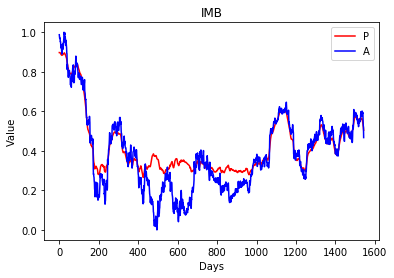

In [54]:


X_test = data[:]
y_test = pred[:]


Pred = Svr.predict(X_test)
print(mean_squared_error(y_test, Pred))

plt.plot(range(len(Pred)),Pred, color = 'red')
plt.plot(range(len(Pred)),pred,color='blue')
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('IMB')
plt.legend('PA')
plt.show()

0.00042694382


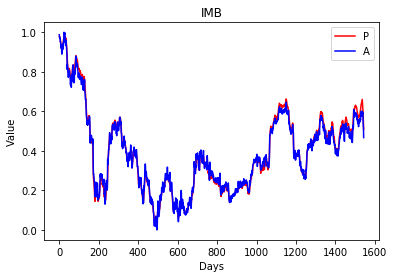

0.8676662320730117


In [56]:
test_X = np.array(X_test).reshape((np.array(X_test).shape[0], 1, np.array(X_test).shape[1]))

Pred = Model.predict(test_X)
print(mean_squared_error(y_test, Pred))
a=0
b=len(Pred)
plt.plot(range(b),Pred[a:a+b], color = 'red')
plt.plot(range(b),y_test[a:a+b],color='blue')
plt.xlabel('Days')
plt.ylabel('Value')
plt.legend('PA')
plt.title('IMB')
plt.show()

actual = y_test[10:]
predicted = Pred[10:]
p = []
a = []
for i in range(len(Pred[:-10])):
    if predicted[i] < y_test[i]:
        p.append(0)
    else:
        p.append(1)
    
    if actual[i] < y_test[i]:
        a.append(0)
    else:
        a.append(1)
        
score = 0
for i in range(len(a)):
    if a[i] == p[i]:
        score += 1
print(score/len(a))

1572.7688148720329